In [1]:
#PyData imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

#Torch-related imports
import torch
import torch.distributions as D
import torch.nn.functional as F
import torch.optim as optim
from scipy.optimize import bisect
from torch.autograd import Function

In [2]:
# Hack to import from a parent directory
import sys
path = '..'
if path not in sys.path:
    sys.path.append(path)
    
from LogitNormal import *
from obs_and_flow import LowerBound

In [3]:
torch.manual_seed(0)
np.random.seed(0)

torch.set_printoptions(precision = 8)

## Draw $\theta \sim p(\theta)$

In [4]:
dt = 0.01
t = 1000

In [5]:
temp_ref = 283
temp_rise = 5 #High estimate of 5 celsius temperature rise by 2100.

prior_scale_factor = 0.333

#SCON theta logit normal distribution parameter details in order of logit(loc), sdev, lower, and upper
u_M_details = torch.Tensor([0.0016, 0.0016 * prior_scale_factor, 0, 0.1])
a_SD_details = torch.Tensor([0.5, 0.5 * prior_scale_factor, 0, 1])
a_DS_details = torch.Tensor([0.5, 0.5 * prior_scale_factor, 0, 1])
a_M_details = torch.Tensor([0.5, 0.5 * prior_scale_factor, 0, 1])
a_MSC_details = torch.Tensor([0.5, 0.5 * prior_scale_factor, 0, 1])
k_S_ref_details = torch.Tensor([0.0005, 0.0005 * prior_scale_factor, 0, 0.01])
k_D_ref_details = torch.Tensor([0.0008, 0.0008 * prior_scale_factor, 0, 0.01])
k_M_ref_details = torch.Tensor([0.0007, 0.0007 * prior_scale_factor, 0, 0.01])
Ea_S_details = torch.Tensor([55, 55 * prior_scale_factor, 10, 100])
Ea_D_details = torch.Tensor([48, 48 * prior_scale_factor, 10, 100])
Ea_M_details = torch.Tensor([48, 48 * prior_scale_factor, 10, 100])
c_SOC_details = torch.Tensor([0.1, 0.1 * prior_scale_factor, 0, 1])
c_DOC_details = torch.Tensor([0.002, 0.002 * prior_scale_factor, 0, 0.02])
c_MBC_details = torch.Tensor([0.002, 0.002 * prior_scale_factor, 0, 0.02])

priors = {'u_M': u_M_details, 'a_SD': a_SD_details, 'a_DS': a_DS_details, 'a_M': a_M_details, 'a_MSC': a_MSC_details, 'k_S_ref': k_S_ref_details, 'k_D_ref': k_D_ref_details, 'k_M_ref': k_M_ref_details, 'Ea_S': Ea_S_details, 'Ea_D': Ea_D_details, 'Ea_M': Ea_M_details, 'c_SOC': c_SOC_details, 'c_DOC': c_DOC_details, 'c_MBC': c_MBC_details}

In [6]:
def find_scale(scale, loc, a, b, target_sd):
    x = RescaledLogitNormal(loc, scale, a, b)
    #print(scale, x.mean, x.stddev)
    return x.stddev - target_sd

In [7]:
SCON_C_priors_dict = {}
SCON_C_params_dict = {}
for k, v in priors.items():
    sigmoid_loc, target_sd, a, b = v
    loc = logit(sigmoid_loc, a, b)
    scale = bisect(find_scale, 1e-6, 100, (loc, a, b, target_sd))
    dist = RescaledLogitNormal(loc, scale, a, b)
    assert dist.stddev - target_sd < 1e-6
    
    SCON_C_priors_dict[k] = torch.tensor((loc, scale, a, b))
    SCON_C_params_dict[k] = dist.sample()

In [8]:
# Save reparameterized prior and sampled theta
sbm_model = 'SCON_C_CO2_logit_alt'
dir_path = '../generated_data/'
save_string = dir_path + f'{sbm_model}_sample_y_t_{t}_dt_{dt}_sd_scale_{prior_scale_factor}'.replace('.','-')
torch.save(SCON_C_priors_dict, save_string + '_hyperparams.pt')
torch.save(SCON_C_params_dict, save_string + '_rsample.pt') 

### Visualize sampled $\theta$

In [9]:
keys = list(SCON_C_priors_dict.keys())
loc, scale, a, b = torch.tensor(list(zip(*(SCON_C_priors_dict[k] for k in keys))))
loc, scale, a, b

(tensor([-4.11903715,  0.00000000,  0.00000000,  0.00000000,  0.00000000,
         -2.94443870, -2.44234705, -2.58668923,  0.00000000, -0.31365752,
         -0.31365752, -2.19722462, -2.19722438, -2.19722438]),
 tensor([0.31610546, 0.74646717, 0.74646717, 0.74646717, 0.74646717, 0.33031842,
         0.34389871, 0.33925658, 0.96848905, 0.82522863, 0.82522863, 0.35355070,
         0.35355061, 0.35355061]),
 tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10., 10., 10.,  0.,  0.,  0.]),
 tensor([1.00000001e-01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
         1.00000000e+00, 9.99999978e-03, 9.99999978e-03, 9.99999978e-03,
         1.00000000e+02, 1.00000000e+02, 1.00000000e+02, 1.00000000e+00,
         1.99999996e-02, 1.99999996e-02]))

In [10]:
dist = RescaledLogitNormal(loc, scale, a, b)
x0 = torch.max(dist.mean - 4*dist.stddev, a).detach()
x1 = torch.min(dist.mean + 4*dist.stddev, b).detach()

num_pts = 1000
x = torch.from_numpy(np.linspace(x0, x1, num_pts))
pdf = torch.exp(dist.log_prob(x)).detach()

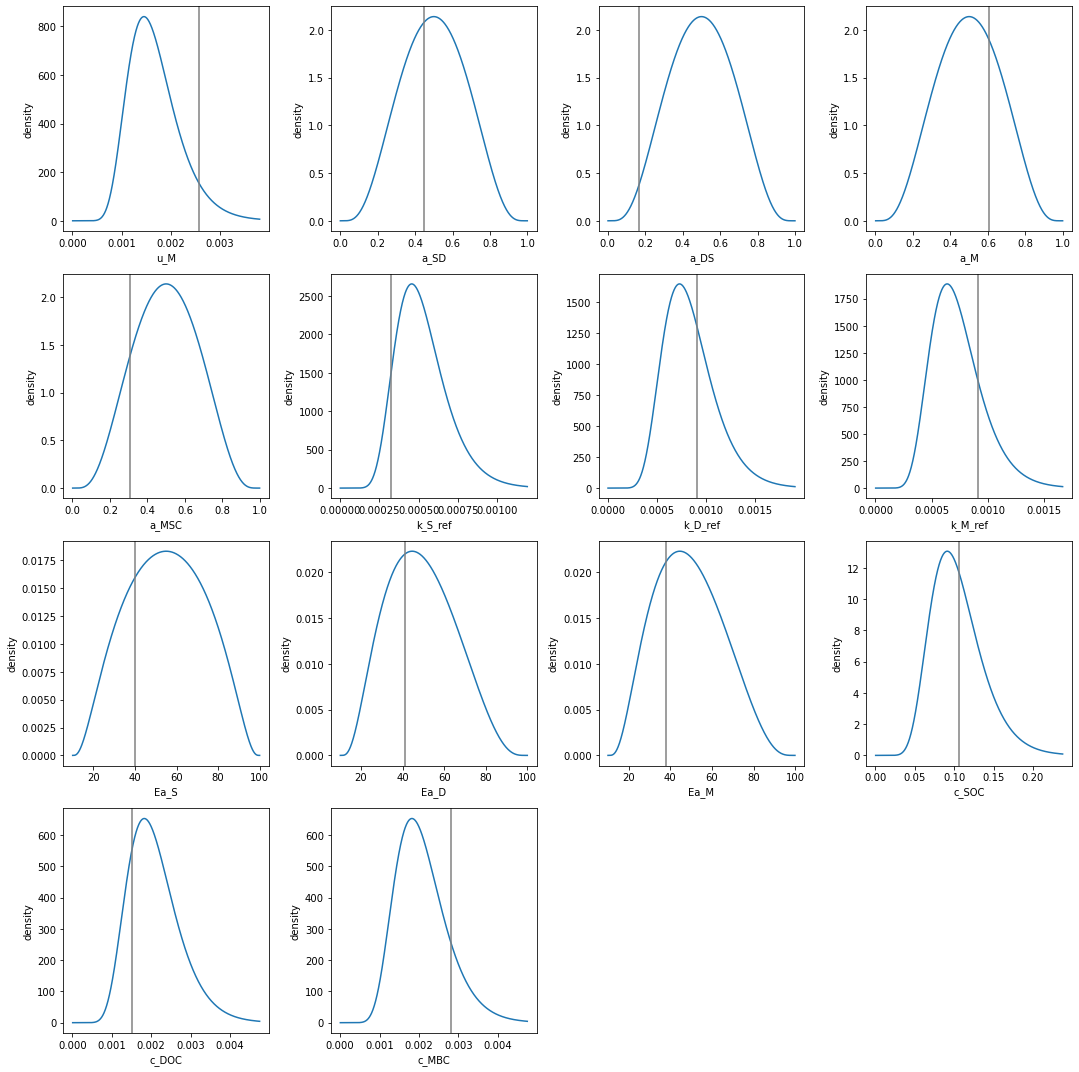

In [11]:
# Save sampled theta values
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
k = 0
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if k < 14:
            key = keys[k]
            ax.plot(x[:, k], pdf[:, k])
            ax.axvline(SCON_C_params_dict[key], color='gray')
            ax.set_xlabel(key)
            ax.set_ylabel('density')
        else:
            fig.delaxes(axes[i, j])
        k += 1  
plt.tight_layout()

## Draw $x, y \sim p(x|\theta) p(y|x)$

In [12]:
def temp_func(t, TEMP_REF, TEMP_RISE):
    temp = TEMP_REF + (TEMP_RISE * t) / (80 * 24 * 365) + 10 * np.sin((2 * np.pi / 24) * t) + 10 * np.sin((2 * np.pi / (24 * 365)) * t)
    return temp

def I_S_func(t):
    return 0.001 + 0.0005 * np.sin((2 * np.pi / (24 * 365)) * t) #Exogenous SOC input function

def I_D_func(t):
    return 0.0001 + 0.00005 * np.sin((2 * np.pi / (24 * 365)) * t) #Exogenous DOC input function

def arrhenius_temp(parameter, temp, Ea, temp_ref):
    '''
    For a parameter with Arrhenius temperature dependence, returns the transformed parameter value.
    0.008314 is the gas constant. Temperatures are in K.
    '''
    decayed_parameter = parameter * np.exp(-Ea / 0.008314 * (1 / temp - 1 / temp_ref))
    return decayed_parameter

def linear_temp(parameter, temp, Q, temp_ref):
    '''
    For a parameter with linear temperature dependence, returns the transformed parameter value.
    Q is the slope of the temperature dependence and is a varying parameter.
    Temperatures are in K.
    '''
    modified_parameter = parameter - Q * (temp - temp_ref)
    return modified_parameter

In [13]:
#Generate data from SBM SDEs
#x in order of SOC, DOC, MBC (and EEC for AWB family models)

def alpha_SCON(x, SCON_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Force temperature-dependent parameters.
    k_S = arrhenius_temp(SCON_params_dict['k_S_ref'], current_temp, SCON_params_dict['Ea_S'], temp_ref)
    k_D = arrhenius_temp(SCON_params_dict['k_D_ref'], current_temp, SCON_params_dict['Ea_D'], temp_ref)
    k_M = arrhenius_temp(SCON_params_dict['k_M_ref'], current_temp, SCON_params_dict['Ea_M'], temp_ref)
    #Evolve drift.
    SOC = I_S + SCON_params_dict['a_DS'] * k_D * x[1] + SCON_params_dict['a_M'] * SCON_params_dict['a_MSC'] * k_M * x[2] - k_S * x[0]
    DOC = I_D + SCON_params_dict['a_SD'] * k_S * x[0] + SCON_params_dict['a_M'] * (1 - SCON_params_dict['a_MSC']) * k_M * x[2] - (SCON_params_dict['u_M'] + k_D) * x[1]
    MBC = SCON_params_dict['u_M'] * x[1] - k_M * x[2]
    return np.array([SOC, DOC, MBC])

def beta_SCON_C(x, SCON_C_params_dict):
    b11 = SCON_C_params_dict['c_SOC']
    b22 = SCON_C_params_dict['c_DOC']
    b33 = SCON_C_params_dict['c_MBC']
    return np.diag([b11, b22, b33])

def beta_SCON_SS(x, SCON_SS_params_dict):
    b11 = SCON_SS_params_dict['s_SOC'] * x[0]
    b22 = SCON_SS_params_dict['s_DOC'] * x[1]
    b33 = SCON_SS_params_dict['s_MBC'] * x[2]
    return np.diag([b11, b22, b33])

def alpha_SAWB(x, SAWB_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Force temperature-dependent parameters.
    u_Q = linear_temp(SAWB_params_dict['u_Q_ref'], current_temp, SAWB_params_dict['Q'], temp_ref)
    V_D = arrhenius_temp(SAWB_params_dict['V_D_ref'], current_temp, SAWB_params_dict['Ea_V_D'], temp_ref)
    V_U = arrhenius_temp(SAWB_params_dict['V_U_ref'], current_temp, SAWB_params_dict['Ea_V_U'], temp_ref)
    #Evolve drift.
    SOC = I_S + SAWB_params_dict['a_MSA'] * SAWB_params_dict['r_M'] * x[2] - ((V_D * x[3] * x[0]) / (SAWB_params_dict['K_D'] + x[0]))
    DOC = I_D + (1 - SAWB_params_dict['a_MSA']) * SAWB_params_dict['r_M'] * x[2] + ((V_D * x[3] * x[0]) / (SAWB_params_dict['K_D'] + x[0])) + SAWB_params_dict['r_L'] * x[3] - ((V_U * x[2] * x[1]) / (SAWB_params_dict['K_U'] + x[1]))
    MBC = (u_Q * (V_U * x[2] * x[1]) / (SAWB_params_dict['K_U'] + x[1])) - (SAWB_params_dict['r_M'] + SAWB_params_dict['r_E']) * x[2]
    EEC = SAWB_params_dict['r_E'] * x[2] - SAWB_params_dict['r_L'] * x[3]
    return np.array([SOC, DOC, MBC, EEC])

def beta_SAWB_C(x, SAWB_C_params_dict):
    b11 = SAWB_C_params_dict['c_SOC']
    b22 = SAWB_C_params_dict['c_DOC']
    b33 = SAWB_C_params_dict['c_MBC']
    b44 = SAWB_C_params_dict['c_EEC']
    return np.diag([b11, b22, b33, b44])

def beta_SAWB_SS(x, SAWB_SS_params_dict):
    b11 = SAWB_SS_params_dict['s_SOC'] * x[0]
    b22 = SAWB_SS_params_dict['s_DOC'] * x[1]
    b33 = SAWB_SS_params_dict['s_MBC'] * x[2]
    b44 = SAWB_SS_params_dict['s_EEC'] * x[3]
    return np.diag([b11, b22, b33, b44])

def alpha_SAWB_ECA(x, SAWB_ECA_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Force temperature-dependent parameters.
    u_Q = linear_temp(SAWB_ECA_params_dict['u_Q_ref'], current_temp, SAWB_ECA_params_dict['Q'], temp_ref)
    V_DE = arrhenius_temp(SAWB_ECA_params_dict['V_DE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_DE'], temp_ref)
    V_UE = arrhenius_temp(SAWB_ECA_params_dict['V_UE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_UE'], temp_ref)
    #Evolve drift.
    SOC = I_S + SAWB_ECA_params_dict['a_MSA'] * SAWB_ECA_params_dict['r_M'] * x[2] - ((V_DE * x[3] * x[0]) / (SAWB_ECA_params_dict['K_DE'] + x[3] + x[0]))
    DOC = I_D + (1 - SAWB_ECA_params_dict['a_MSA']) * SAWB_ECA_params_dict['r_M'] * x[2] + ((V_DE * x[3] * x[0]) / (SAWB_ECA_params_dict['K_DE'] + x[3] + x[0])) + SAWB_ECA_params_dict['r_L'] * x[3] - ((V_UE * x[2] * x[1]) / (SAWB_ECA_params_dict['K_UE'] + x[2] + x[1]))
    MBC = (u_Q * (V_UE * x[2] * x[1]) / (SAWB_ECA_params_dict['K_UE'] + x[2] + x[1])) - (SAWB_ECA_params_dict['r_M'] + SAWB_ECA_params_dict['r_E']) * x[2]
    EEC = SAWB_ECA_params_dict['r_E'] * x[2] - SAWB_ECA_params_dict['r_L'] * x[3]
    return np.array([SOC, DOC, MBC, EEC])

def beta_SAWB_ECA_C(x, SAWB_ECA_C_params_dict):
    b11 = SAWB_ECA_C_params_dict['c_SOC']
    b22 = SAWB_ECA_C_params_dict['c_DOC']
    b33 = SAWB_ECA_C_params_dict['c_MBC']
    b44 = SAWB_ECA_C_params_dict['c_EEC']
    return np.diag([b11, b22, b33, b44])

def beta_SAWB_ECA_SS(x, SAWB_ECA_SS_params_dict):
    b11 = SAWB_ECA_SS_params_dict['s_SOC'] * x[0]
    b22 = SAWB_ECA_SS_params_dict['s_DOC'] * x[1]
    b33 = SAWB_ECA_SS_params_dict['s_MBC'] * x[2]
    b44 = SAWB_ECA_SS_params_dict['s_EEC'] * x[3]
    return np.diag([b11, b22, b33, b44])
    
def get_SBM_SDE_euler_maruyama_y(ALPHA, BETA, X0, T, DT, THETA_DICT, I_S_FUNC, I_D_FUNC, TEMP_FUNC, OBS_EVERY, OBS_ERROR_SCALE, model_fam, lower_bound = 1e-4):
    state_dim = 0
    if model_fam == 'SCON':
        state_dim = 3
    elif model_fam == 'SAWB':
        state_dim = 4
    N = int(T / DT) + 1
    M = int(T / OBS_EVERY) + 1
    x = np.zeros([state_dim, N])
    X0_array = np.array(X0)
    X0_sample = np.random.normal(loc = X0_array, scale = OBS_ERROR_SCALE * X0_array) #Add noise to initial conditions of x.
    X0_sample[X0_sample < lower_bound] = lower_bound #Bound initial conditions above 0. 
    print('X0_sample = ', X0_sample)
    x[:, 0] = X0_sample
    hour = 0
    for i in range(1, N):
        hour += DT
        I_S = I_S_FUNC(hour)
        #print('I_S', I_S)
        I_D = I_D_FUNC(hour)
        #print('I_D', I_D)
        current_temp = TEMP_FUNC(hour, temp_ref, temp_rise)
        #print('current_temp', current_temp)
        #Take Euler-Maruyama step. Note: np.random.normal takes std while np.random.multivariate_normal takes cov.
        x[:, i] = np.random.multivariate_normal(mean = x[:, i - 1] + ALPHA(x[:, i - 1], THETA_DICT, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp) * DT, cov = BETA(x[:, i - 1], THETA_DICT) * DT)
        x[:, i][x[:, i] < lower_bound] = lower_bound #Bound all x above 0.
        #print('x at i', x[:, i])
    x_for_y = x[:, 0::int(OBS_EVERY / DT)] #Slice x based on observation interval to generate y.
    obs_var_scale = OBS_ERROR_SCALE * x_for_y.mean(1)
    y = x_for_y + obs_var_scale[:, np.newaxis] * np.random.normal(loc = 0, scale = 1, size = x_for_y.shape) #Introduce observation error based on mean state sizes to generate y.
    y[y < lower_bound] = lower_bound #Bound all y above 0.
    return {'y': y, 't_y': np.arange(0, T + DT, OBS_EVERY), 'y_std': obs_var_scale, 'x': x, 't_x': np.arange(0, T + DT, DT)}

def get_SBM_SDE_euler_maruyama_y_det(ALPHA, X0, T, DT, THETA_DICT, I_S_FUNC, I_D_FUNC, TEMP_FUNC, OBS_EVERY, OBS_ERROR_SCALE, model_fam, lower_bound = 1e-4):
    state_dim = 0
    if model_fam == 'SCON':
        state_dim = 3
    elif model_fam == 'SAWB':
        state_dim = 4
    N = int(T / DT) + 1
    M = int(T / OBS_EVERY) + 1
    x = np.zeros([state_dim, N])
    X0_array = np.array(X0)
    X0_sample = np.random.normal(loc = X0_array, scale = OBS_ERROR_SCALE * X0_array) #Add noise to initial conditions of x.
    X0_sample[X0_sample < lower_bound] = lower_bound #Bound initial conditions above 0. 
    print('X0_sample = ', X0_sample)
    x[:, 0] = X0_sample 
    hour = 0
    for i in range(1, N):
        hour += DT
        I_S = I_S_FUNC(hour)
        #print('I_S', I_S)
        I_D = I_D_FUNC(hour)
        #print('I_D', I_D)
        current_temp = TEMP_FUNC(hour, temp_ref, temp_rise)
        #print('current_temp', current_temp)
        #Take Euler.
        x[:, i] = x[:, i - 1] + ALPHA(x[:, i - 1], THETA_DICT, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp) * DT
        x[:, i][x[:, i] < lower_bound] = lower_bound #Bound all x above 0.
        #print('x at i', x[:, i])
    x_for_y = x[:, 0::int(OBS_EVERY / DT)] #Slice x based on observation interval to generate y.
    obs_var_scale = OBS_ERROR_SCALE * x_for_y.mean(1)
    y = x_for_y + obs_var_scale[:, np.newaxis] * np.random.normal(loc = 0, scale = 1, size = x_for_y.shape) #Introduce observation error based on mean state sizes to generate y.
    y[y < lower_bound] = lower_bound #Bound all y above 0.
    return {'y': y, 't_y': np.arange(0, T + DT, OBS_EVERY), 'y_std': obs_var_scale, 'x': x, 't_x': np.arange(0, T + DT, DT)}

In [14]:
x0_SCON = [65, 0.4, 2.5]
obs_every = 5
obs_error_scale = 0.1

In [15]:
y_dict = get_SBM_SDE_euler_maruyama_y(alpha_SCON, beta_SCON_C, x0_SCON, t, dt, SCON_C_params_dict, I_S_func, I_D_func, temp_func, obs_every, obs_error_scale, 'SCON')

X0_sample =  [76.46634025  0.41600629  2.7446845 ]


In [16]:
#Save CSV of stochastic path.
df_y = pd.DataFrame(data = {'hour': y_dict['t_y'], 'SOC': y_dict['y'][0, :], 'DOC': y_dict['y'][1, :], 'MBC': y_dict['y'][2, :]})
df_y.to_csv(save_string + '.csv', index = False)

In [17]:
print(df_y)

       hour        SOC       DOC       MBC
0       0.0  75.312714  0.226536  3.335168
1       5.0  83.842740  0.324076  1.587031
2      10.0  80.736258  0.431337  2.496692
3      15.0  83.312598  0.703767  1.203558
4      20.0  89.508138  0.424451  1.995307
..      ...        ...       ...       ...
196   980.0  68.293936  4.582704  7.232698
197   985.0  56.222257  4.509365  6.594042
198   990.0  79.631915  4.254842  6.588201
199   995.0  68.981498  4.515608  7.161668
200  1000.0  73.235395  4.104096  7.437018

[201 rows x 4 columns]


### Visualize sampled $x$

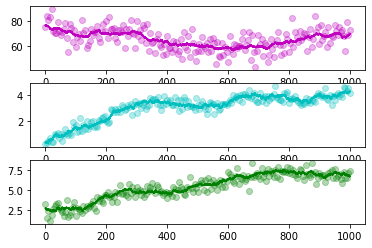

In [18]:
fig, axs = plt.subplots(3)
axs[0].plot(y_dict['t_x'], y_dict['x'][0, :], color = "m", label = 'SOC x')
axs[0].scatter(y_dict['t_y'], y_dict['y'][0, :], color = "m", alpha = 0.3, label = 'SOC y')
axs[1].plot(y_dict['t_x'], y_dict['x'][1, :], color = "c", label = 'DOC x')
axs[1].scatter(y_dict['t_y'], y_dict['y'][1, :], color = "c", alpha = 0.3, label = 'DOC y')
axs[2].plot(y_dict['t_x'], y_dict['x'][2, :], color = "g", label = 'MBC x')
axs[2].scatter(y_dict['t_y'], y_dict['y'][2, :], color = "g", alpha = 0.3, label = 'MBC y')

In [19]:
fig.savefig(save_string + '.png', dpi = 300)

## Generate deterministic $x$

In [20]:
y_det_dict = get_SBM_SDE_euler_maruyama_y_det(alpha_SCON, x0_SCON, t, dt, SCON_C_params_dict, I_S_func, I_D_func, temp_func, obs_every, obs_error_scale, 'SCON')

X0_sample =  [76.29446592  0.43387731  2.72269042]


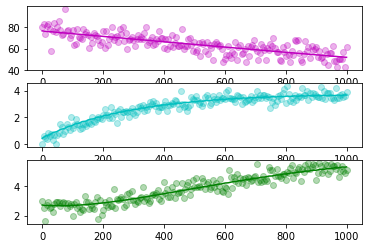

In [21]:
fig2, axs2 = plt.subplots(3)
axs2[0].plot(y_det_dict['t_x'], y_det_dict['x'][0, :], color = "m", label = 'SOC x')
axs2[0].scatter(y_det_dict['t_y'], y_det_dict['y'][0, :], color = "m", alpha = 0.3, label = 'SOC y')
axs2[1].plot(y_det_dict['t_x'], y_det_dict['x'][1, :], color = "c", label = 'DOC x')
axs2[1].scatter(y_det_dict['t_y'], y_det_dict['y'][1, :], color = "c", alpha = 0.3, label = 'DOC y')
axs2[2].plot(y_det_dict['t_x'], y_det_dict['x'][2, :], color = "g", label = 'MBC x')
axs2[2].scatter(y_det_dict['t_y'], y_det_dict['y'][2, :], color = "g", alpha = 0.3, label = 'MBC y')

In [22]:
save_string_det = f'{sbm_model}_prior_alt_sample_det_y_t_{t}_dt_{dt}_sd_scale_{prior_scale_factor}'.replace('.','-')
fig2.savefig(save_string_det + '.png', dpi = 300)

In [23]:
df_y_det = pd.DataFrame(data = {'hour': y_det_dict['t_y'], 'SOC': y_det_dict['y'][0, :], 'DOC': y_det_dict['y'][1, :], 'MBC': y_det_dict['y'][2, :]})
df_y_det.to_csv(save_string_det + '.csv', index = False)

In [24]:
print(df_y_det)

       hour        SOC       DOC       MBC
0       0.0  79.797873  0.000100  2.986223
1       5.0  82.432388  0.643964  2.500609
2      10.0  73.636138  0.479435  1.641598
3      15.0  80.806320  0.414270  2.721435
4      20.0  82.238422  0.843031  2.940213
..      ...        ...       ...       ...
196   980.0  49.988303  3.667427  5.073684
197   985.0  50.277874  3.707411  5.374114
198   990.0  57.035422  3.501553  5.046718
199   995.0  42.659074  3.622249  4.896429
200  1000.0  61.226068  3.902602  5.145763

[201 rows x 4 columns]
